In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from iaaft import surrogates
from multiproc import compute_VAR
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from nld_utils import calculate_fnn_stat, embed_signal, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Van der Pol Oscillator

$$\dot x = y\\
{\displaystyle {\dot {y}}=\mu (1-x^{2})y-x}.$$

In [3]:
total_time = 100 # s
dt = 0.001
T = int(total_time/dt)
# x0 = np.random.randn()*0.01
# y0 = np.random.randn()*0.01
x0 = 0
y0 = 2

mu = 4

perturbations = np.zeros((T, 2))
perturbation_start = 50 # s
perturbation_end = 50.5 # s
# perturbation_sd = 0.05
perturbation_sd = 0
perturbations[int(perturbation_start/dt):int(perturbation_end/dt)] = np.random.randn(int(perturbation_end/dt) - int(perturbation_start/dt), 2)*perturbation_sd 

In [4]:
x = np.zeros(T)
y = np.zeros(T)

x[0] = x0
y[0] = y0
for t in tqdm(range(1, T)):
    x[t] = x[t - 1] + dt*(y[t - 1]) + perturbations[t, 0]
    y[t] = y[t - 1] + dt*(mu*(1 - x[t-1]**2)*y[t-1] - x[t-1]) + perturbations[t, 1]

  0%|          | 0/99999 [00:00<?, ?it/s]

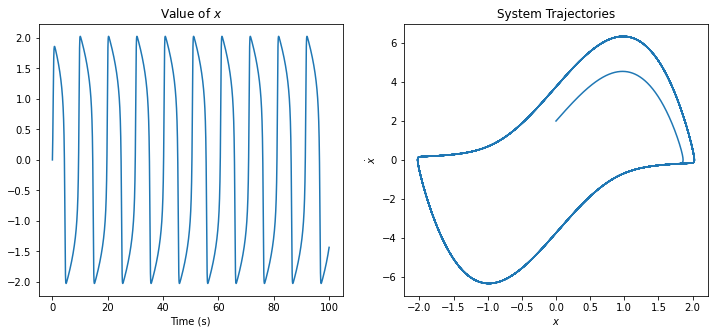

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(T)*dt, x, label='x')
plt.xlabel('Time (s)')
plt.title('Value of $x$')
plt.subplot(1, 2, 2)
plt.plot(x, y)
plt.xlabel('$x$')
plt.ylabel('$\dot{x}$')
plt.title("System Trajectories")
plt.show()

# Functions

In [16]:
def perform_VAR_p_analysis(data, windows, max_lag, T_pred=25, num_window_samples=5, dt=0.001):
    lags = np.arange(1, max_lag + 1)
    
    grid_search_df = []
    iterator = tqdm(total = len(windows)*len(lags))
    for window in windows:
        stride = window
        min_ind = int(0/stride)
        max_ind = int((data.shape[0]*dt - window - T_pred*dt)/stride)
        possible_inds = np.arange(min_ind, max_ind + 1)
        window_inds = np.random.choice(possible_inds, size=(np.min([num_window_samples, len(possible_inds)])), replace=False)
    #     num_windows = int(np.floor((data.shape[0]-window)/stride)+1)
        for p in lags:
    #         for i in range(num_windows):
            for i in window_inds:
                start_ind = i*int(stride/dt)
                start_time = i*stride
                end_ind = i*int(stride/dt) + int(window/dt)
                end_time = i*stride + window
                if end_ind + T_pred <= data.shape[0]:

                    window_data = data[start_ind:end_ind]
                    results = compute_VAR_p(window_data, p)
                    test_data = data[end_ind - p:end_ind + T_pred]

                    train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
                    train_mse = ((train_prediction - train_true_vals)**2).mean()
                    test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
    #                 print(test_prediction.shape)
                    test_mse = ((test_prediction - test_true_vals)**2).mean()
                    persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

                    # ADD TO DICTIONARY
                    results['train_mse'] = train_mse
                    results['test_mse'] = test_mse
                    results['persistence_baseline'] = persistence_baseline

                    # ADD TIMESTAMPS
                    results['start_ind'] = start_ind
                    results['end_ind'] = end_ind
                    results['start_time'] = start_time
                    results['end_time'] = end_time

                    # ADD PARAMETERS
                    results['window'] = window
                    results['stride'] = stride
                    results['p'] = p
                    results['T_pred'] = T_pred

                    grid_search_df.append(results)
            iterator.update()
    iterator.close()
    grid_search_df = pd.DataFrame(grid_search_df)
    
    test_mse_mat = np.zeros((len(windows), len(lags)))
    for i, window in enumerate(windows):
        for j, p in enumerate(lags):
            test_mse_mat[i, j] = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].test_mse.mean()
    
    def pick_2d_optimum(mat, thresh=0.95):
        true_min = mat.min()
        i_vals, j_vals = np.where(mat*thresh - true_min <= 0)
        selected_i = np.min(i_vals)
        selected_j = np.min(j_vals[i_vals == selected_i])
        selected_i, selected_j

        return selected_i, selected_j
    thresh = 0.9
    w_ind, p_ind = pick_2d_optimum(test_mse_mat, thresh)
    
    window = windows[w_ind]
    p = lags[p_ind]
#     p = 1
    
    
    VAR_results = []
    stride = window
    num_windows = int(np.floor((data.shape[0]-int(window/dt))/int(stride/dt)+1))
    for i in tqdm(range(num_windows)):
        start_ind = i*int(stride/dt)
        start_time = i*stride
        end_ind = i*int(stride/dt) + int(window/dt)
        end_time = i*stride + window
        if end_ind + T_pred <= data.shape[0]:

            window_data = data[start_ind:end_ind]
            results = compute_VAR_p(window_data, p)
            test_data = data[end_ind - p:end_ind + T_pred]

            train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'])
            train_mse = ((train_prediction - train_true_vals)**2).mean()
            test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'])
    #                 print(test_prediction.shape)
            test_mse = ((test_prediction - test_true_vals)**2).mean()
            persistence_baseline = ((data[end_ind:end_ind + T_pred] - data[end_ind - 1:end_ind + T_pred -1])**2).mean()

            # ADD TO DICTIONARY
            results['train_mse'] = train_mse
            results['test_mse'] = test_mse
            results['persistence_baseline'] = persistence_baseline

            # ADD TIMESTAMPS
            results['start_ind'] = start_ind
            results['end_ind'] = end_ind
            results['start_time'] = start_time
            results['end_time'] = end_time

            # ADD PARAMETERS
            results['window'] = window
            results['stride'] = stride
            results['p'] = p
            results['T_pred'] = T_pred

            VAR_results.append(results)
    VAR_results = pd.DataFrame(VAR_results)
    
    return VAR_results, grid_search_df, test_mse_mat, window, p

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(highcut, fs, order=5):
    return butter(order, highcut, fs=fs, btype='low')

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# VAR(p) Analysis

In [7]:
plt.style.use('../../sci_style.py')

In [8]:
# sig_in = x
# nlags = 250
# bins = 64
# max_m = 10
# p = 2
# r = 10

# # pick tau
# delayed_mi = np.zeros(nlags + 1)

# n = len(sig_in)
# for tau_ in tqdm(range(nlags + 1)):
#     delayed_mi[tau_] = delay.mi(sig_in[tau_:], sig_in[:n - tau_], bins=bins)
# local_min_locs = scipy.signal.argrelextrema(delayed_mi, np.less)[0]


# tau = local_min_locs[0]

# # pick m
# m_vals = np.arange(1, max_m + 1)
# fraction_fnn = np.zeros(m_vals.shape)

# for i, m in tqdm(enumerate(m_vals), total=len(m_vals)):
#     embedding = embed_signal(sig_in, m, tau=tau)
#     nn_indices, _ = get_nn_indices(embedding, p=p)
#     fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)
#     fraction_fnn[i] = fraction_greater

# if sum(fraction_fnn < 0.1) > 0:
#     m = np.argmax(fraction_fnn < 0.1) + 1
# else:
#     m = m_vals[-1]

In [9]:
# print(f"m = {m}, tau = {tau}")
# de = embed_signal(x, m, tau)
# data = np.vstack([x, y]).T
# signals = {'mu = 4': data, 'mu = 4 de': de}
# indices = np.arange(2)

In [10]:
def RK4(func, t0, y0, t_bound, dt=0.1, verbose=False):
    y_vals = np.zeros((int(t_bound/dt), len(y0)))
    t_vals = np.arange(y_vals.shape[0])*dt
    t = t0
    y = y0
    y_vals[0] = y
    for i, t in tqdm(enumerate(t_vals), disable=not verbose, total=len(t_vals)):
        k1 = func(t, y)
        k2 = func(t + dt/2, y + dt*k1/2)
        k3 = func(t + dt/2, y + dt*k2/2)
        k4 = func(t + dt, y + dt*k3)
        y += (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dt
        y_vals[i] = y
    
    return y_vals, t_vals

In [11]:
indices = np.arange(2)
signals = {}
signal_analysis = {}

# total_time = 250 # s
total_time = 1000 # s
dt = 0.05
subsample_step = 1
T = int(total_time/dt)
# mu_vals = [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4]
mu_vals = [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5]
for mu in tqdm(mu_vals):
    x0 = np.random.randn()*2
    y0 = np.random.randn()*2
#     x0 = 0
#     y0 = 1

    # ------------
    # EULER
    # -----------
#     x = np.zeros(T)
#     y = np.zeros(T)
    
#     x[0] = x0
#     y[0] = y0
#     for t in range(1, T):
#         x[t] = x[t - 1] + dt*(y[t - 1])
#         y[t] = y[t - 1] + dt*(mu*(1 - x[t-1]**2)*y[t-1] - x[t-1])

#     data = np.vstack([x, y]).T
    
    # ------------
    # RUNGE KUTTA
    # -----------
    dynamic_noise_sd = 0.8
    y, t = RK4(lambda t, v: np.array([v[1] + np.random.randn()*dynamic_noise_sd, mu*(1 - v[0]**2)*v[1] - v[0] + np.random.randn()*dynamic_noise_sd]), 0, (np.random.randn()*2, np.random.randn()*2), t_bound=total_time, dt=dt, verbose=False)
    data = y
    
    signals[f"mu = {mu}"] = data[np.arange(0, data.shape[0], subsample_step)]
        
signal_analysis = {}

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
signal_analysis = {}

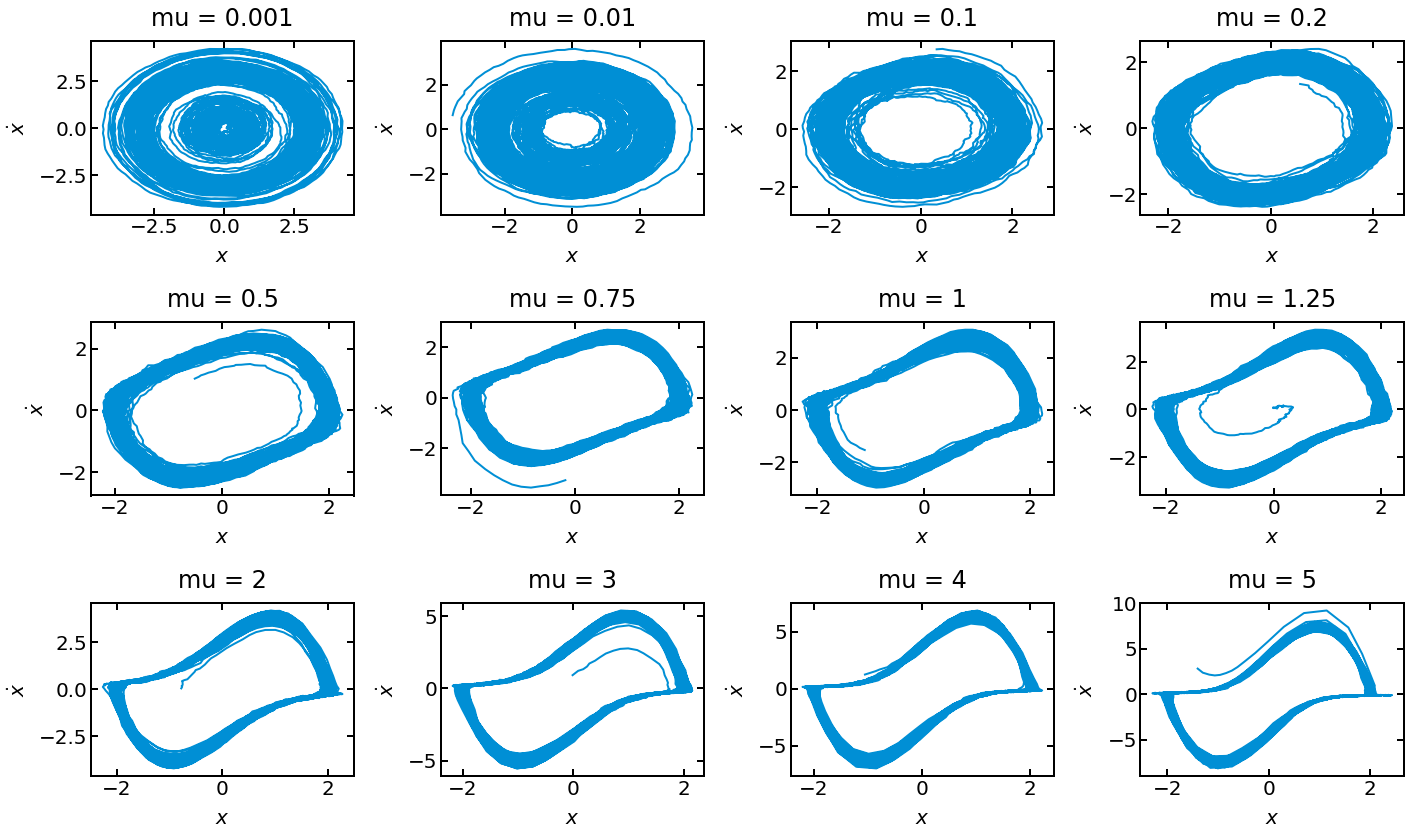

In [12]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 12))

for i, (key, signal) in enumerate(signals.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    ax.plot(signal[:, 0], signal[:, 1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    ax.set_title(f"{key}")
plt.tight_layout()
plt.show()

In [13]:
# windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.1, 0.5)]
# windows = np.arange(30, 201, 10)
windows = np.hstack([np.arange(1, 20.1, 1)])
# windows = np.hstack([np.arange(2, 10.1, 1), np.arange(10, 51, 5), np.arange(60, 120, 10)])
# windows = np.hstack([np.arange(20, 51, 5), np.arange(60, 120, 10)])
# windows = np.hstack([np.arange(0.05, 0.101, 0.01), [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]])
# windows = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5]
max_lag = 15
lags = np.arange(1, max_lag + 1)
# T_pred = 500
T_pred = 25
# num_window_samples = 5
num_window_samples = 5

In [17]:
for key, signal in signals.items():
    if key not in signal_analysis.keys():
        print(f"now computing: {key}")
        data = signal[:, indices]
        VAR_results, grid_search_df, test_mse_mat, window, p = perform_VAR_p_analysis(data, windows, max_lag, T_pred=T_pred, num_window_samples=num_window_samples, dt=dt*subsample_step)
        signal_analysis[key] = dict(
            VAR_results=VAR_results,
            grid_search_df=grid_search_df,
            test_mse_mat=test_mse_mat,
            window=window,
            p=p
        )

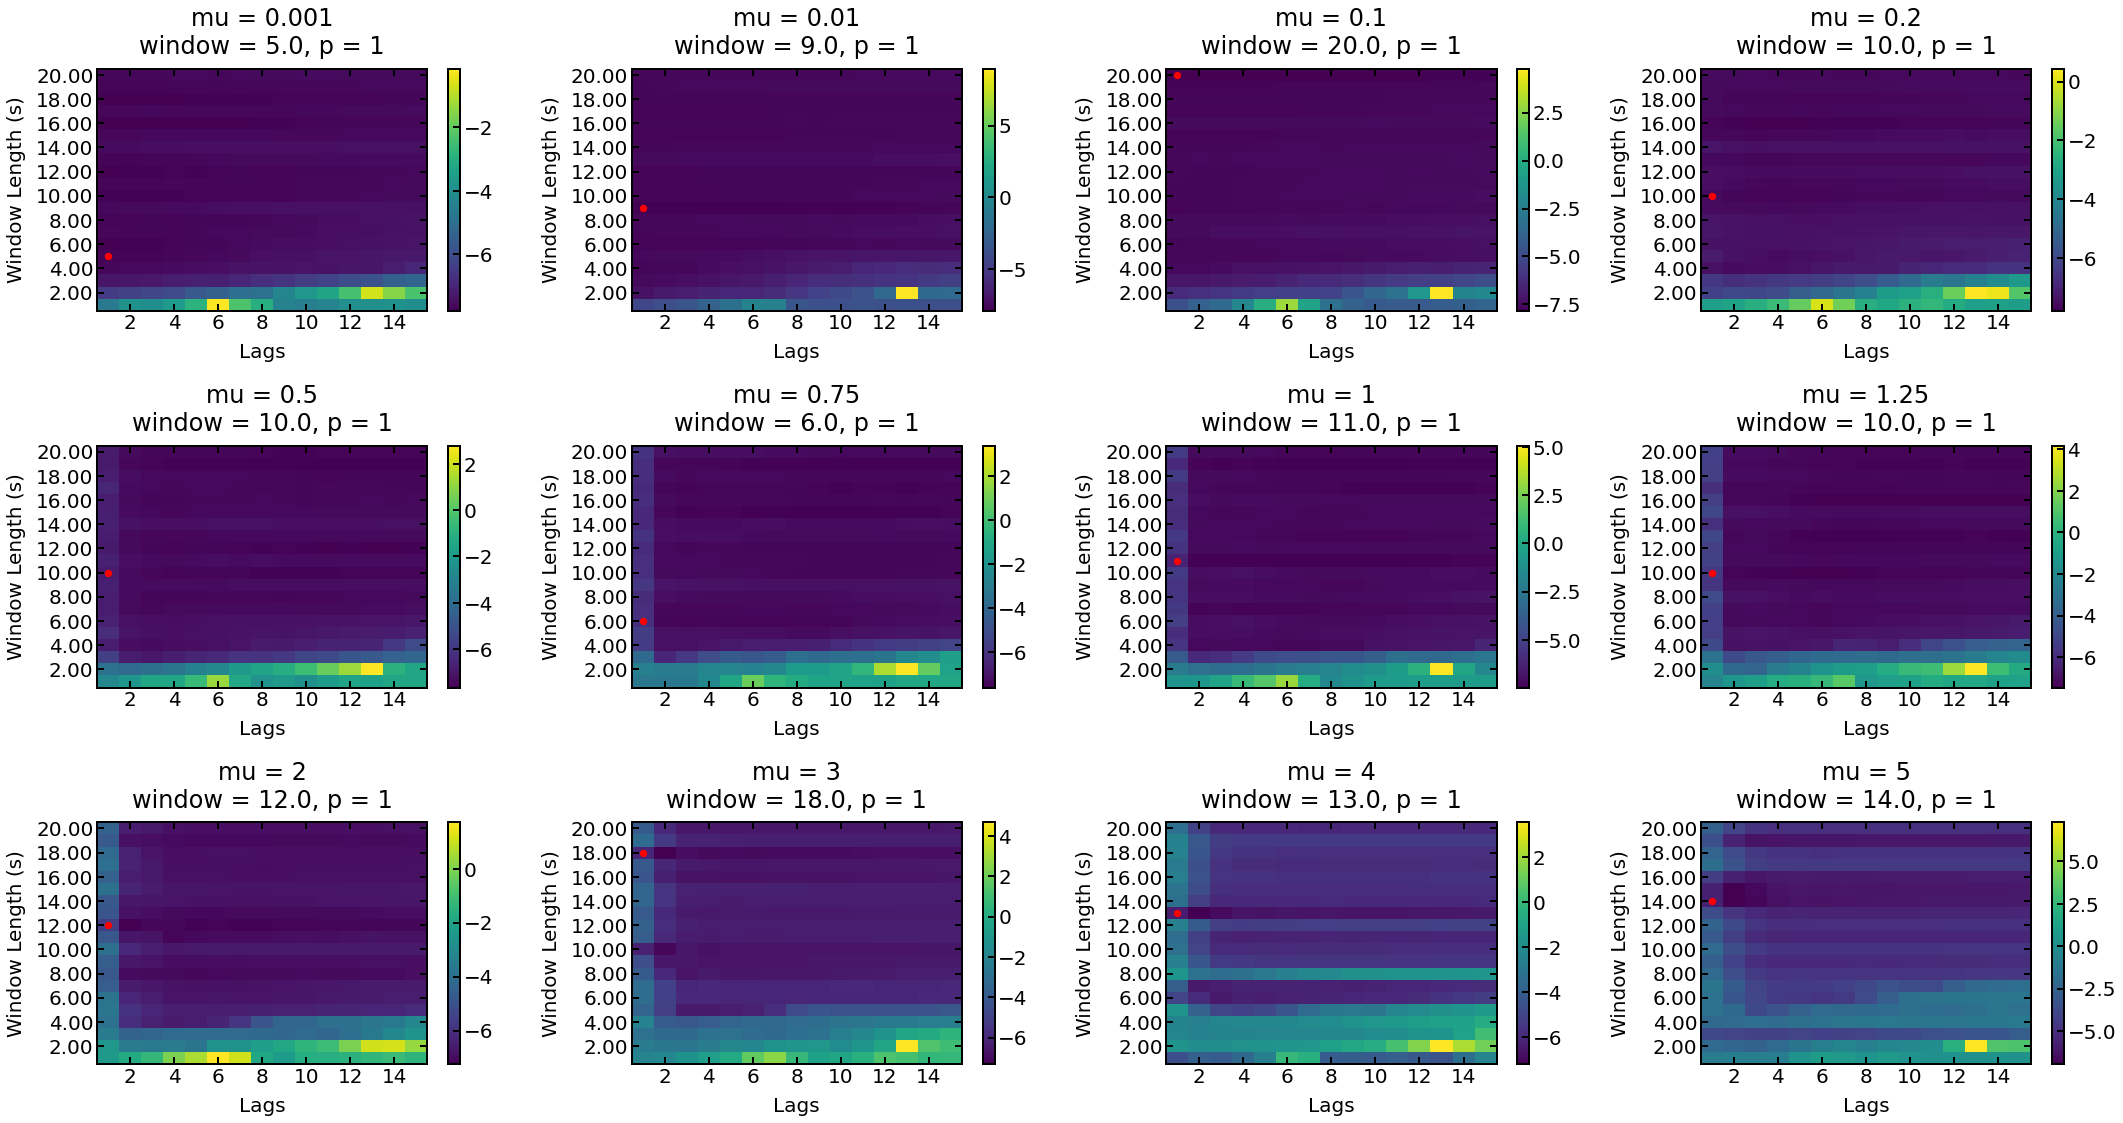

In [18]:
plt.style.use('../../sci_style.py')
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    log_test_mse_mat = np.log(signal_info['test_mse_mat'])
    im = ax.pcolormesh(log_test_mse_mat)
    ax.set_xticks(np.arange(1, max_lag, 2) + 0.5)
    ax.set_xticklabels([lags[i] for i in np.arange(1, max_lag, 2)])
    ax.set_yticks(np.arange(1, len(windows), 2) + 0.5)
    ax.set_yticklabels([f"{windows[i]:.2f}" for i in np.arange(1, len(windows), 2)])
    ax.set_xlabel('Lags')
    ax.set_ylabel('Window Length (s)')
    ax.set_title(f"{key}\nwindow = {signal_info['window']}, p = {signal_info['p']}")
    fig.colorbar(im, ax=ax)
    p_ind = np.where(lags == signal_info['p'])[0][0]
    w_ind = np.where(np.array(windows) == signal_info['window'])[0][0]
    ax.scatter([p_ind + 0.5], [w_ind + 0.5], color='red', s=40, label='min')
plt.tight_layout()

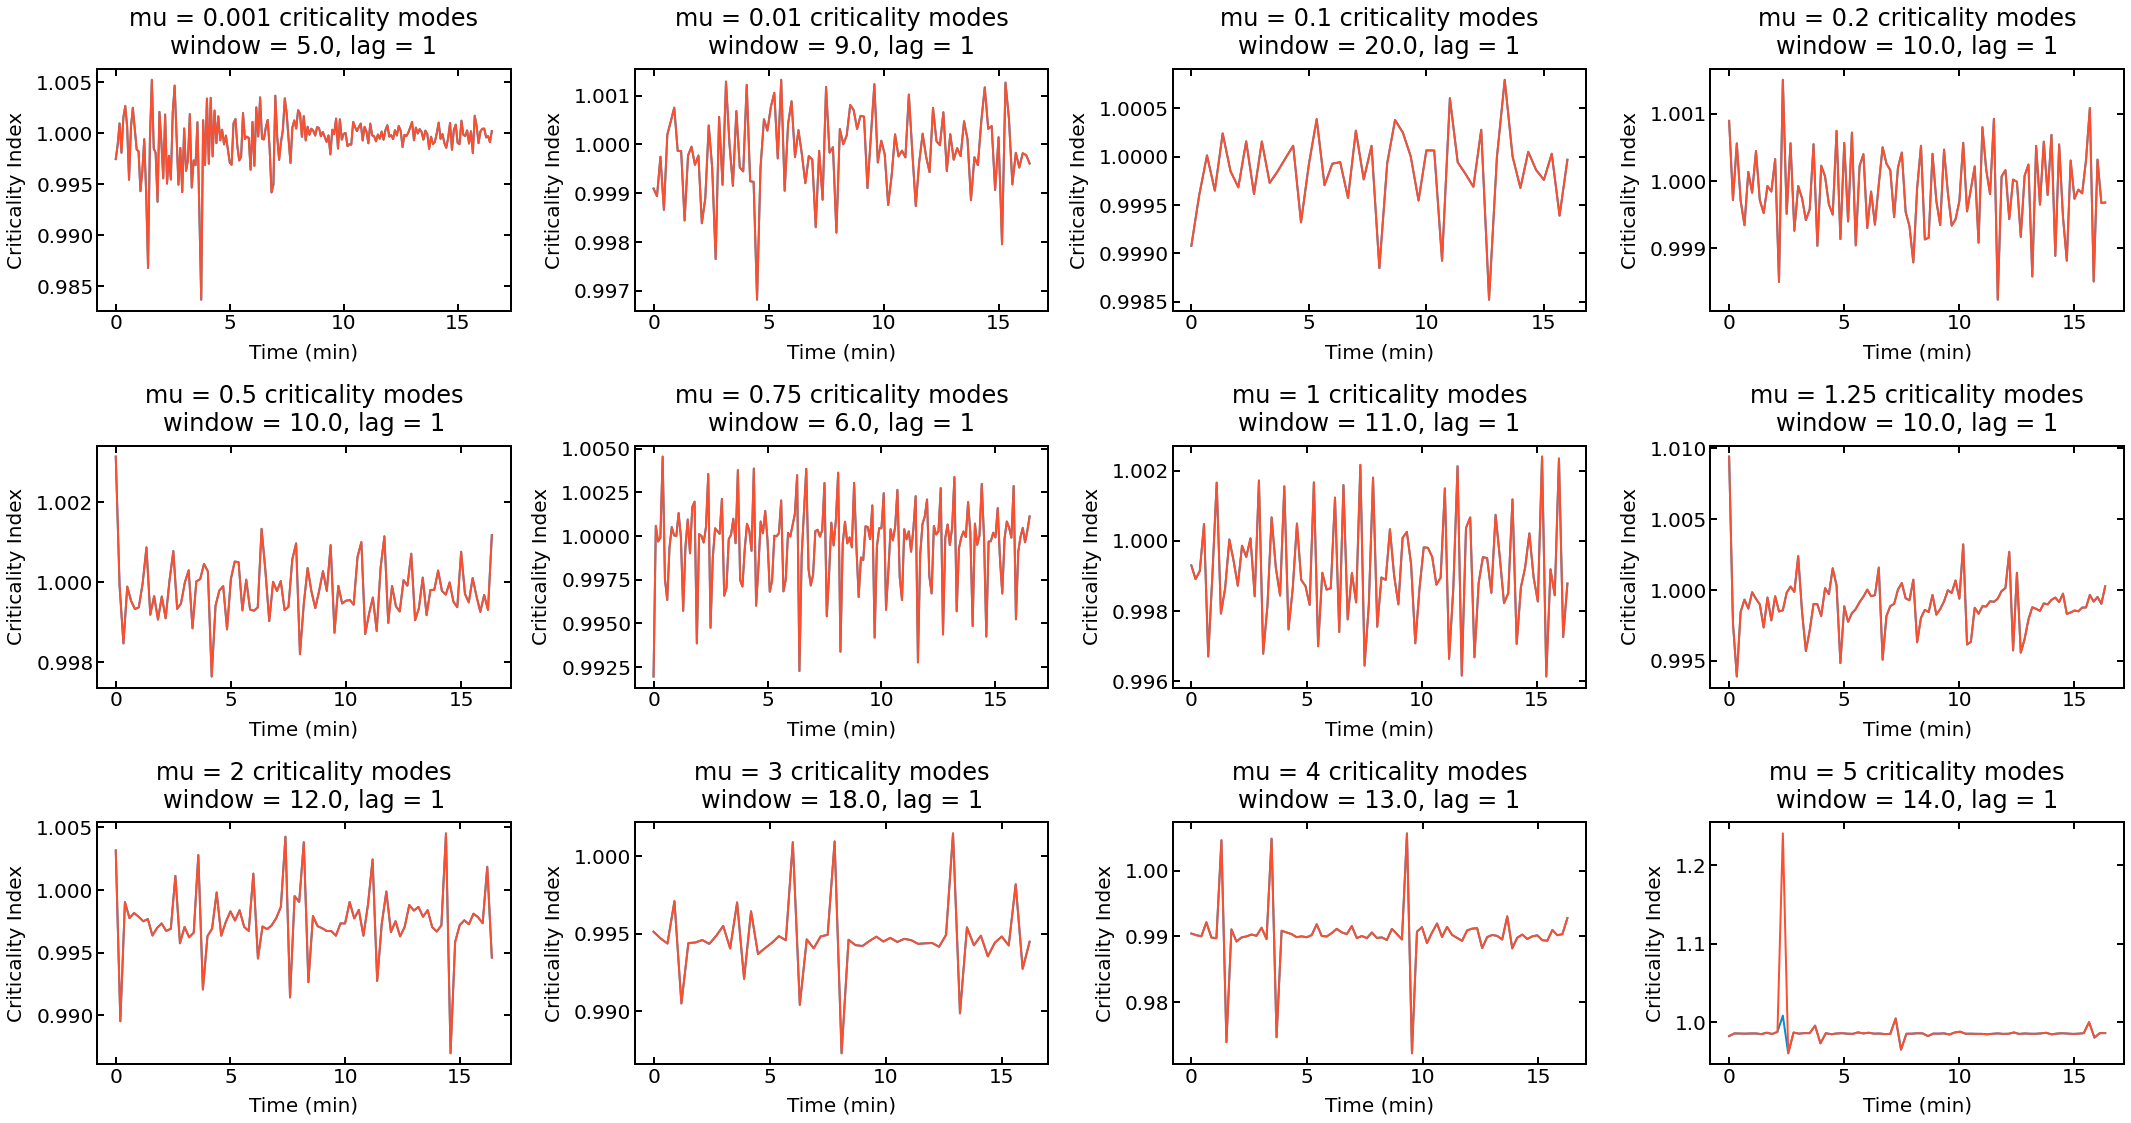

In [19]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
        
    VAR_results = signal_info['VAR_results']
    mode_criticalities = np.zeros((len(VAR_results), len(VAR_results.criticality_inds.iloc[0])))
    for i, row in VAR_results.iterrows():
        mode_criticalities[i] = np.sort(row.criticality_inds)
    for i in range(len(VAR_results.criticality_inds.iloc[0])):
        ax.plot((VAR_results.start_time)/60, mode_criticalities[:, i])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Criticality Index')
    ax.set_title(f"{key} criticality modes\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

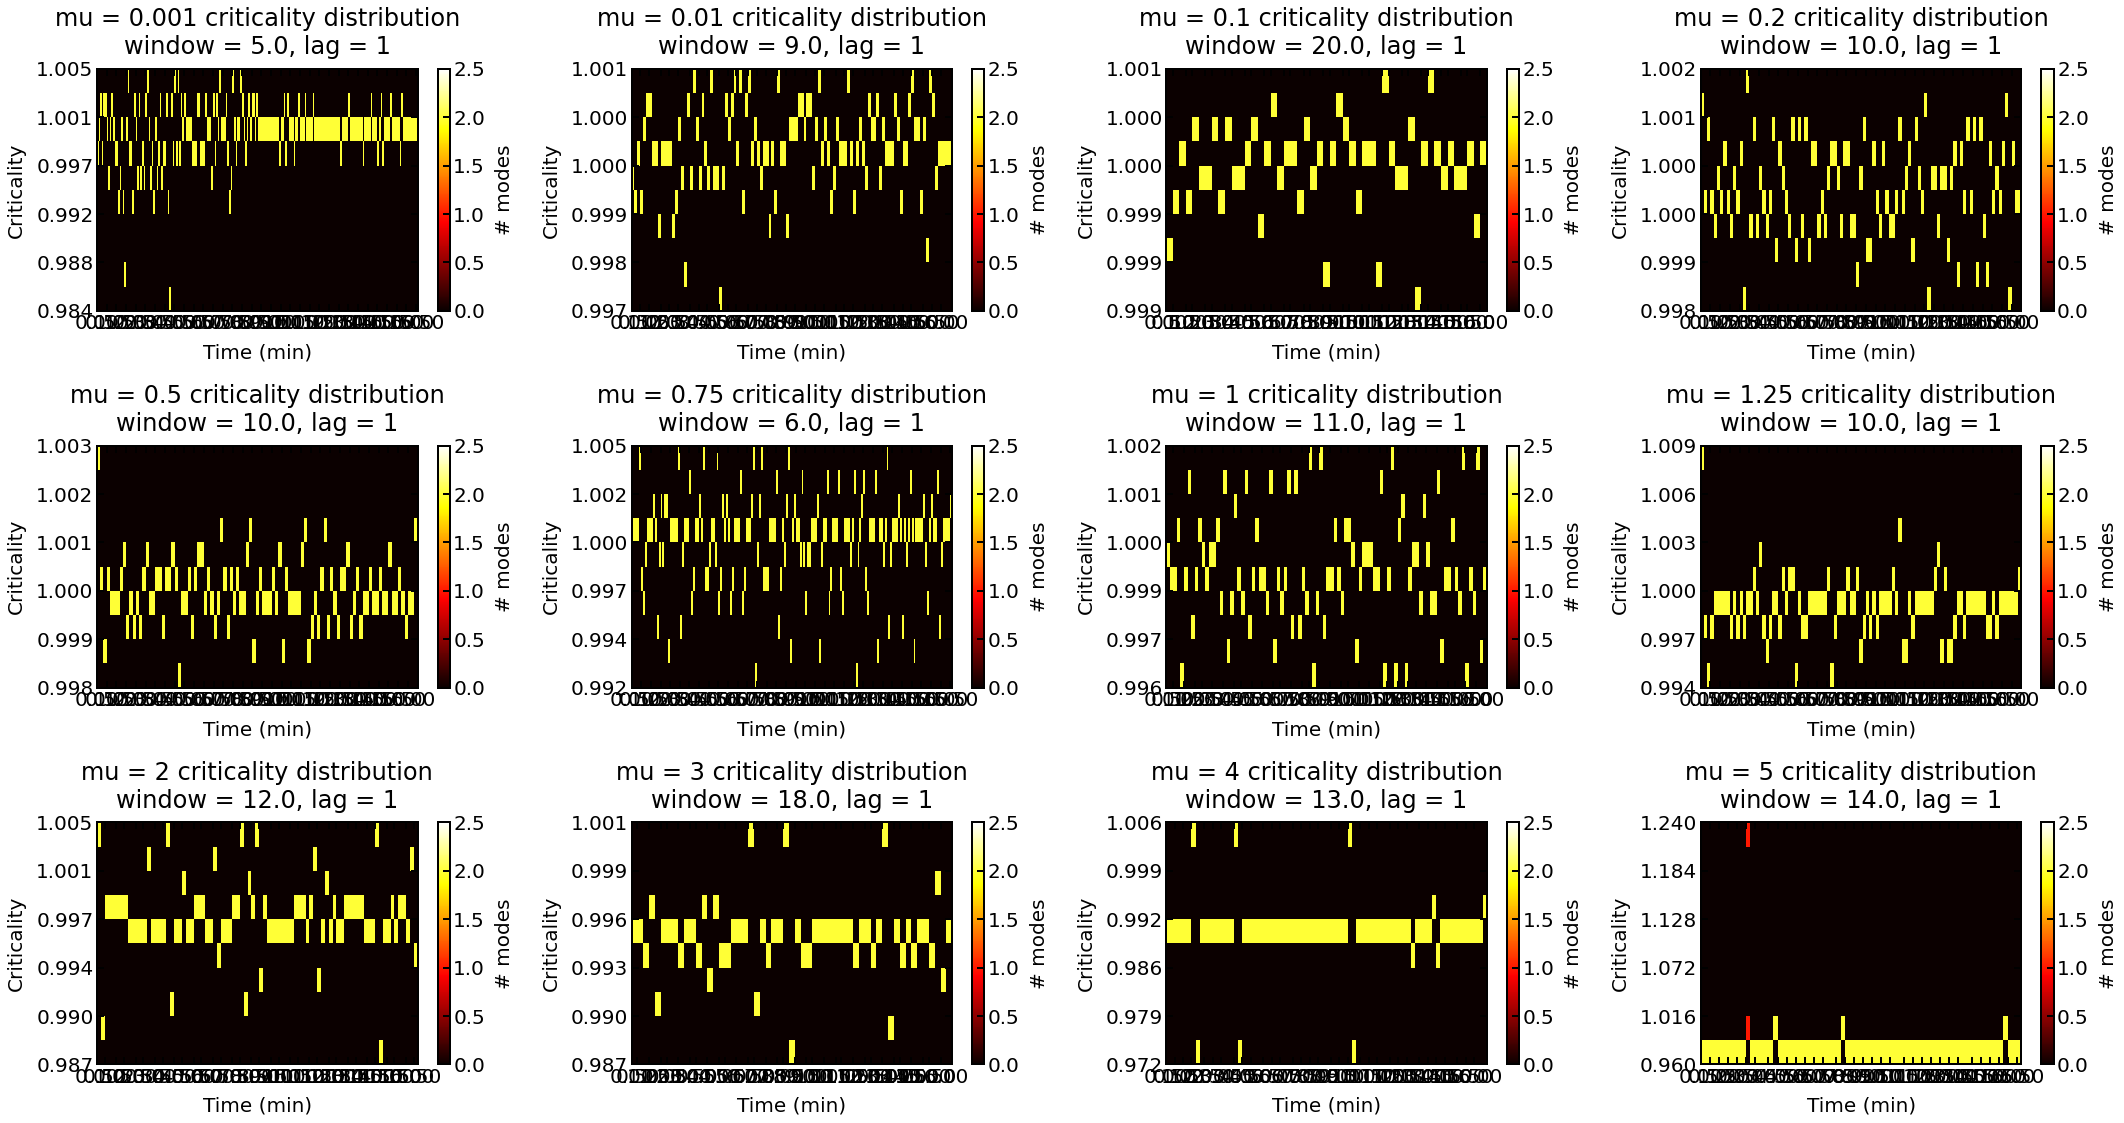

In [20]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    
    VAR_results = signal_info['VAR_results']
    
    stride = VAR_results.stride.iloc[0]
    bin_nums = 10
    bin_min = np.concatenate(VAR_results.criticality_inds.to_numpy()).min()
    bin_max = np.concatenate(VAR_results.criticality_inds.to_numpy()).max()
    bins = [(bin_max - bin_min)*i/bin_nums + bin_min for i in range(bin_nums + 1 )]
    criticality_prob_dist = np.zeros((VAR_results.criticality_inds.shape[0], bin_nums))
    for t in range(VAR_results.criticality_inds.shape[0]):
        criticality_prob_dist[t] = np.histogram(VAR_results.criticality_inds[t], bins=bins)[0]
    start_times = np.arange(VAR_results.criticality_inds.shape[0])*stride/60
    T_max = VAR_results.criticality_inds.shape[0]*stride
    im = ax.pcolormesh(criticality_prob_dist.T, cmap='hot', vmin=criticality_prob_dist.min(), vmax=criticality_prob_dist.max()*1.25)
    ax.set_xticks([int(i/stride) for i in np.arange(0, T_max, 30)])
    ax.set_xticklabels([f"{(int(i))/60:.2f}" for i in np.arange(0, T_max, 30)])
    ax.set_yticks(np.arange(0, bin_nums + 1, 2))
    ax.set_yticklabels([f"{b:.3f}" for b in np.array(bins)[np.arange(0, bin_nums + 1, 2)]])
    cb = fig.colorbar(im, ax=ax)
    cb.set_label(label='# modes')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Criticality")
    ax.set_title(f"{key} criticality distribution\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

In [21]:
def lambda_2(mu):
    if mu < 2:
        return -mu  - (1/16)*(mu ** 3) + (263/18432)*(mu ** 5)
    elif mu == 2:
        return -1.2*mu
    elif mu == 3:
        return -1.3*mu
    elif mu == 4:
        return -1.4*mu
    elif mu == 5:
        return -1.45*mu
    else:
        return None
# https://arxiv.org/pdf/2111.12198.pdf

In [22]:
# plt.plot(np.arange(signals['mu = 0.001'].shape[0])[:1000]*dt*subsample_step, signals['mu = 0.001'][:1000, 0])
# plt.xlabel('Time (s)')
# plt.show()

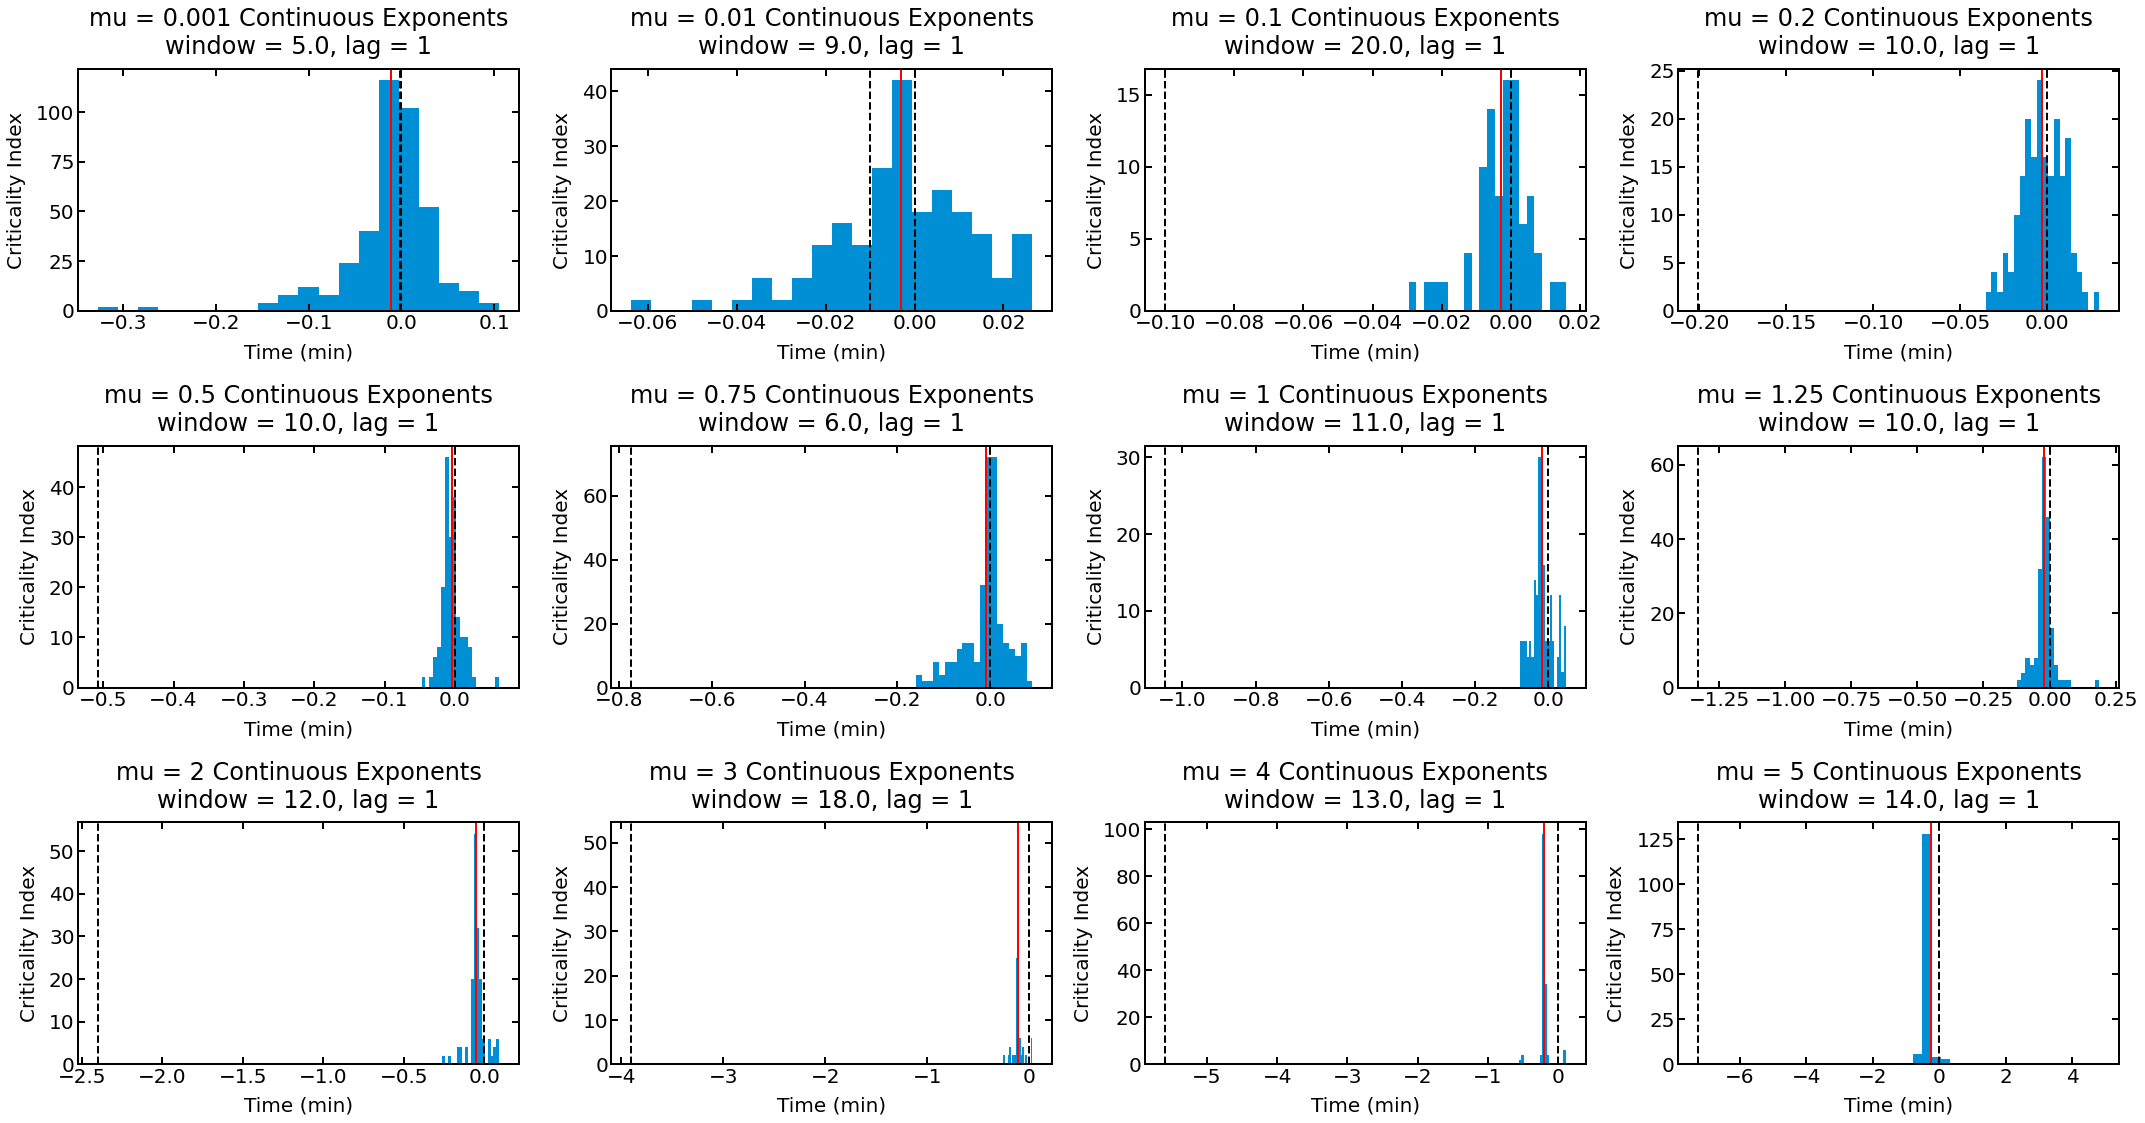

In [23]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(30, 16))

mean_vals = []
mean_top_10 = []
mean_bottom_10 = []
for i, (key, signal_info) in enumerate(signal_analysis.items()):
    if rows == 1 and cols == 1:
        ax = axs
    elif rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
        
    VAR_results = signal_info['VAR_results']
    criticalities = np.hstack(VAR_results.criticality_inds)
    continuous_exps = (criticalities - 1)/(dt*subsample_step)
    ax.hist(continuous_exps, bins=20)
    ax.axvline(lambda_2(mu_vals[i]), c='k', linestyle='--')
    ax.axvline(0, c='k', linestyle='--')
    ax.axvline(np.mean(continuous_exps), c='r')
    mean_vals.append(np.mean(continuous_exps))
    mean_bottom_10.append(continuous_exps[continuous_exps <= np.percentile(continuous_exps, 10)].mean())
    mean_top_10.append(continuous_exps[continuous_exps >= np.percentile(continuous_exps, 90)].mean())
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Criticality Index')
    ax.set_title(f"{key} Continuous Exponents\nwindow = {signal_info['window']}, lag = {signal_info['p']}")
plt.tight_layout()
plt.show()

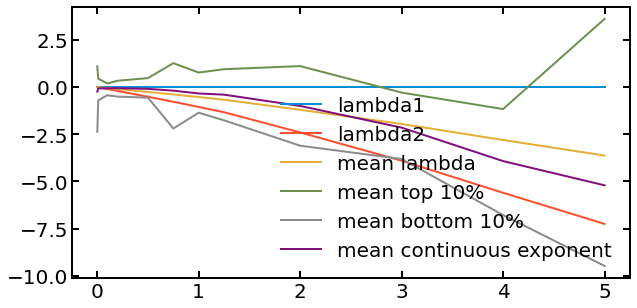

In [24]:
plt.plot(mu_vals, np.zeros(len(mu_vals)), label='lambda1')
plt.plot(mu_vals, [lambda_2(mu_vals[i]) for i in range(len(mu_vals))], label='lambda2')
plt.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], label='mean lambda')
plt.plot(mu_vals, np.array(mean_top_10)*20, label='mean top 10%')
plt.plot(mu_vals, np.array(mean_bottom_10)*20, label='mean bottom 10%')
plt.plot(mu_vals, np.array(mean_vals)*20, label='mean continuous exponent')
plt.legend()
plt.show()

# Nonlinear Dynamics

In [359]:
sys.path.append('../nonlinear-dynamics')
from core import *

def compute_A_mat(coefs):
    N = coefs.shape[1]
    p = coefs.shape[0]
    A = np.zeros((N*p, N*p))
    for i in range(p):
        A[:N, i*N:(i + 1)*N] = coefs[i]
        if i < p - 1:
            A[(i+1)*N:(i + 2)*N, :][:, i*N:(i + 1)*N] = np.eye(N)
    
    return A

In [360]:
for key, signal_info in signal_analysis.items():
    VAR_results = signal_info['VAR_results']
    
    T = int(VAR_results.end_time.iloc[-1]/(dt*subsample_step))
    
    N = VAR_results.coefs.iloc[0].shape[1]
    p = VAR_results.p.iloc[0]
    
    js = np.zeros((T, int(N*p), int(N*p)))
    for i, row in VAR_results.iterrows():
        js[row.start_ind:row.end_ind] = compute_A_mat(row.coefs) 
    
    break

In [367]:
lams = estimate_stability_using_particle(js, 100, test_eigenvectors=True)

  0%|          | 0/9000 [00:00<?, ?it/s]

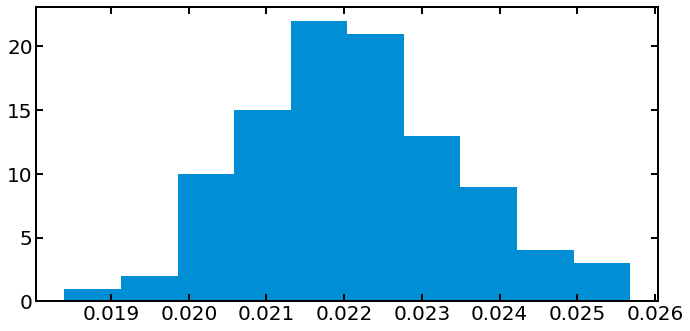

In [368]:
plt.hist(lams/(dt*subsample_step))
plt.tight_layout()
plt.show()

# Predictions

In [25]:
mu = 5
grid_search_df = signal_analysis[f'mu = {mu}']['grid_search_df']

In [54]:
window = 14
p = 1
row = grid_search_df[np.logical_and(grid_search_df.window == window, grid_search_df.p == p)].iloc[0]

In [55]:
# T_pred_new = row.T_pred
T_pred_new = 500

In [56]:
if row.end_ind + T_pred_new > signals[f'mu = {mu}'].shape[0]:
    end_ind = row.end_ind - (row.end_ind + T_pred_new - signals[f'mu = {mu}'].shape[0])
else:
    end_ind = row.end_ind
data = signals[f'mu = {mu}'][end_ind - p:end_ind + T_pred_new]
prediction, true_vals = predict_VAR_p(data, row.coefs, row.intercept)

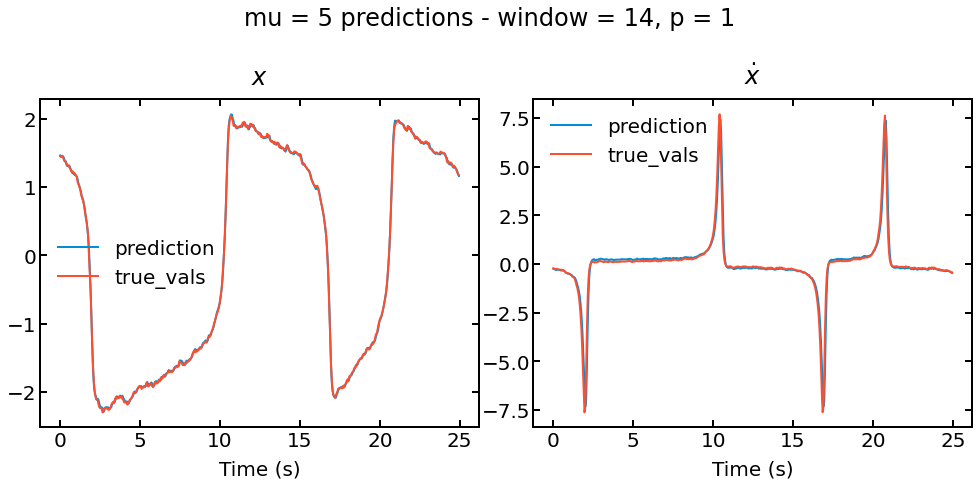

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

plt.suptitle(f'mu = {mu} predictions - window = {window}, p = {p}')
ax = axs[0]
ax.plot(np.arange(T_pred_new)*dt*subsample_step, prediction[:, 0], label='prediction')
ax.plot(np.arange(T_pred_new)*dt*subsample_step, true_vals[:, 0], label='true_vals')
ax.set_xlabel('Time (s)')
ax.legend()
ax.set_title('$x$')
ax = axs[1]
ax.plot(np.arange(T_pred_new)*dt*subsample_step, prediction[:, 1], label='prediction')
ax.plot(np.arange(T_pred_new)*dt*subsample_step, true_vals[:, 1], label='true_vals')
ax.set_xlabel('Time (s)')
ax.legend()
ax.set_title(r'$\dot{x}$')
plt.tight_layout()
plt.show()

In [62]:
np.abs(np.linalg.eigvals(row.coefs[0]))

array([0.98506925, 0.98506925])